In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter

from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter


In [2]:
df = pd.read_csv('BDHSC_SCC_2025_synth_data.csv')
regimen_columns = ["Base_Drug_Combo", "Comp_INI", "Comp_NNRTI", "ExtraPI", "ExtraPk_En"]
df["Regimen"] = df[regimen_columns].astype(str).agg("_".join, axis=1)
df

,ID,Month,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL_M,CD4_M,Drug_M,VL,CD4,RelCD4,Regimen
0,8130128040812561626,0,1,3,0,0,3,5,0,0,1,1,29.944271,793.458300,30.834505,0_0_3_5_0
1,8130128040812561626,1,1,3,0,0,3,5,0,0,0,1,29.241980,467.418900,30.355980,0_0_3_5_0
2,8130128040812561626,2,1,3,0,0,3,5,0,0,0,1,28.748991,465.124850,30.405320,0_0_3_5_0
3,8130128040812561626,3,1,3,0,0,3,5,0,0,0,1,28.101835,692.006900,30.248816,0_0_3_5_0
4,8130128040812561626,4,1,3,0,0,3,5,0,0,0,1,28.813837,641.757140,29.944712,0_0_3_5_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11234155,18117203277056921559,55,1,4,0,2,3,5,1,0,0,1,8.454356,4045.386412,37.574126,0_2_3_5_1
11234156,18117203277056921559,56,1,4,0,2,3,5,1,0,0,1,110.025330,2685.636079,23.047465,0_2_3_5_1
11234157,18117203277056921559,57,1,4,0,2,3,5,1,0,0,1,9.441938,3689.274170,38.173028,0_2_3_5_1
11234158,18117203277056921559,58,1,4,0,2,3,5,1,0,0,1,18.851511,2755.832797,30.159213,0_2_3_5_1


In [3]:
df_sorted = df.sort_values(['ID', 'Month'])
df_sorted['Regimen_Shift'] = (df_sorted.groupby('ID')['Regimen'].shift() != df_sorted['Regimen']).astype(int)
df_sorted['Regimen_Start'] = df_sorted.groupby('ID')['Regimen_Shift'].cumsum()

# Split into regimen intervals
intervals = df_sorted.groupby(['ID', 'Regimen_Start']).agg(
    Start=('Month', 'min'),
    End=('Month', 'max'),
    Regimen=('Regimen', 'first'),
    VL=('VL', lambda x: list(x)),
    CD4=('CD4', lambda x: list(x))
).reset_index()

In [4]:
def track_outcomes(group):
    """Track first suppression/CD4 recovery and retain covariates."""
    vl = group['VL']
    cd4 = group['CD4']
    time_points = group['Month']
    
    # Viral load outcomes
    vl_250_time = next((t for t, val in zip(time_points, vl) if val <= 250), None)
    vl_50_time = next((t for t, val in zip(time_points, vl) if val <= 50), None)
    
    # CD4 recovery
    cd4_500_time = next((t for t, val in zip(time_points, cd4) if val > 500), None)
    
    return pd.Series({
        'VL_250_time': vl_250_time,
        'VL_50_time': vl_50_time,
        'CD4_500_time': cd4_500_time,
        'VL_250_Censored': 1 if vl_250_time is None else 0,
        'VL_50_Censored': 1 if vl_50_time is None else 0,
        'CD4_500_Censored': 1 if cd4_500_time is None else 0,
        'Gender': group['Gender'].iloc[0],  # Add baseline covariates
        'Ethnicity': group['Ethnic'].iloc[0],
        'Baseline_VL': group['VL'].iloc[0],
        'Baseline_CD4': group['CD4'].iloc[0],
        'Baseline_CD4_percent': group['RelCD4']
    })

# Apply outcome tracking
outcomes = df_sorted.groupby(['ID', 'Regimen_Start']).apply(track_outcomes).reset_index()
intervals_outcomes = pd.merge(intervals, outcomes, on=['ID', 'Regimen_Start'])

/var/folders/bw/5y6vvgld6yv27r1hv8xx5dq80000gn/T/ipykernel_8374/1735706620.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outcomes = df_sorted.groupby(['ID', 'Regimen_Start']).apply(track_outcomes).reset_index()


In [ ]:
def filter_intervals(df, mode):
    """Filter intervals where start time < target time (or target not achieved)."""

    if mode == 'vl50':
        mask = (df['Start'] < df['VL_50_time']) | (df['VL_50_Censored'] == 1)
    elif mode == 'vl250':
        mask = (df['Start'] < df['VL_250_time']) | (df['VL_250_Censored'] == 1)
    else:
        mask = (df['Start'] < df['CD4_500_time']) | (df['CD4_500_Censored'] == 1)
    df = df[mask]
    return df[df['Start'] != df['End']]

In [9]:
def cox(mode):
    filtered_intervals_outcomes = filter_intervals(intervals_outcomes, mode)

    tv_data = []
    for _, row in filtered_intervals_outcomes.iterrows():
        start = row['Start']
        if mode == 'vl50':
            end = row['End'] if row['VL_50_Censored'] == 1 else row['VL_50_time']
        elif mode == 'vl250':
            end = row['End'] if row['VL_250_Censored'] == 1 else row['VL_250_time']
        else:
            end = row['End'] if row['CD4_500_Censored'] == 1 else row['CD4_500_time']
        
        tv_data.append({
            'Patient ID': row['ID'],
            'start': start,
            'stop': end,
            'gender': row['Gender'],
            'ethnicity': row['Ethnicity'],
            'censor': row['VL_50_Censored'],
            'Regimen': row['Regimen'],
            'Baseline_VL': row['Baseline_VL'],
            'Baseline_CD4': row['Baseline_CD4']
        })

    tv_df = pd.DataFrame(tv_data)
    counts = tv_df["Regimen"].value_counts()
    common_regimens = counts[counts > 1000].index

    tv_df["Regimen_lumped"] = tv_df["Regimen"].apply(
        lambda x: x if x in common_regimens else "Other"
    )

    tv_df["gender"] = tv_df["gender"].astype("category")
    tv_df["ethnicity"] = tv_df["ethnicity"].astype("category")
    tv_df = pd.get_dummies(tv_df, columns=["Regimen_lumped", "gender", "ethnicity"], drop_first=True)

    tv_df.drop(['Regimen'], axis=1, inplace=True)

    ctv = CoxTimeVaryingFitter()
    ctv.fit(
        tv_df,
        id_col="Patient ID",
        event_col="censor",
        start_col="start",
        stop_col="stop",
        show_progress=True
    )
    ctv.print_summary()
    return ctv

In [74]:
ctv_vl50 = cox('vl50')

/Users/matthew/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Regimen_lumped_0_1_3_5_1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['censor'].astype(bool)
>>> print(df.loc[events, 'Regimen_lumped_0_1_3_5_1'].var())
>>> print(df.loc[~events, 'Regimen_lumped_0_1_3_5_1'].var())

A very low variance means that the column Regimen_lumped_0_1_3_5_1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.30e+00, step_size = 0.9500, log_lik = -2353017.67625, newton_decrement = 8.27e+04, seconds_since_start = 4.9
Iteration 2: norm_delta = 6.44e-01, step_size = 0.9500, log_lik = -2372672.62788, newton_decrement = 7.51e+04, seconds_since_start = 11.1
Iteration 3: norm_delta = 1.83e-01, step_size = 0.9500, log_lik = -2298531.34231, newton_decrement = 6.71e+03, seconds_since_start = 16.6
Iteration 4: norm_delta = 5.51e-02, step_size = 1.0000, log_lik = -2291270.14108, newton_decrement = 6.99e+02, seconds_since_start = 19.9
Iteration 5: norm_delta = 1.61e-02, step_size = 1.0000, log_lik = -2290480.01145, newton_decrement = 4.37e+01, seconds_since_start = 23.8
Iteration 6: norm_delta = 1.53e-03, step_size = 1.0000, log_lik = -2290434.00568, newton_decrement = 3.32e-01, seconds_since_start = 30.6
Iteration 7: norm_delta = 1.26e-05, step_size = 1.0000, log_lik = -2290433.67228, newton_decrement = 2.22e-05, seconds_since_start = 36.7
Iteration 8: norm_delta = 8.45e-10,

<lifelines.CoxTimeVaryingFitter: fitted with 369024 periods, 161477 subjects, 214268 events>
         event col = 'censor'
number of subjects = 161477
 number of periods = 369024
  number of events = 214268
partial log-likelihood = -2290433.67
  time fit was run = 2025-02-08 00:51:47 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
Baseline_VL              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Baseline_CD4             -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Regimen_lumped_0_1_2_5_0  1.18      3.25      0.02            1.14            1.22                3.12                3.38
Regimen_lumped_0_1_3_5_0  0.63      1.88      0.02            0.60            0.66                1.82                1.94
Regimen_lumped_0_1_3_5_1  1.25      3.49      0.03            1.19            1.31                3.29                3.69
Regimen_lumped_0_2_2_5_0  1.62      5.06      0.03            1.56            1.69                4.74                5.40
Regimen_lumped_0_2_3_5_0  1.11      3.03      0.02            1.07            1.15                2.90                3.16
Regimen_lumped_0_2_3_5_1 -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
Regimen_lumped_0_3_0_5_0  0.30      1.35      0.03            0.25            0.35                1.28                1.42
Regimen_lumped_0_3_1_5_0  0.07      1.08      0.01            0.04            0.10                1.04                1.11
Regimen_lumped_0_3_2_5_0 -0.49      0.61      0.01           -0.52           -0.46                0.60                0.63
Regimen_lumped_0_3_3_5_0  1.14      3.12      0.02            1.10            1.18                3.01                3.24
Regimen_lumped_1_0_0_5_0  0.79      2.21      0.03            0.74            0.84                2.09                2.33
Regimen_lumped_1_0_3_5_0 -0.89      0.41      0.02           -0.92           -0.86                0.40                0.42
Regimen_lumped_1_1_0_5_0  0.68      1.98      0.03            0.62            0.75                1.86                2.11
Regimen_lumped_1_1_3_5_0  0.45      1.57      0.02            0.41            0.48                1.51                1.62
Regimen_lumped_1_2_3_5_0  0.65      1.91      0.04            0.56            0.73                1.76                2.08
Regimen_lumped_1_3_0_5_0 -0.35      0.71      0.02           -0.39           -0.31                0.68                0.74
Regimen_lumped_1_3_1_5_0  0.82      2.27      0.03            0.76            0.88                2.14                2.41
Regimen_lumped_1_3_3_0_0  0.96      2.61      0.02            0.92            1.00                2.51                2.72
Regimen_lumped_1_3_3_1_0  1.92      6.79      0.03            1.85            1.98                6.37                7.25
Regimen_lumped_1_3_3_5_0  0.69      1.99      0.03            0.64            0.74                1.90                2.10
Regimen_lumped_2_2_3_5_1  0.53      1.69      0.02            0.48            0.57                1.62                1.77
Regimen_lumped_2_3_2_5_0  0.62      1.86      0.04            0.54            0.70                1.71                2.01
Regimen_lumped_2_3_3_5_1  1.00      2.71      0.04            0.93            1.07                2.53                2.90
Regimen_lumped_3_1_3_1_0  1.17      3.22      0.03            1.11            1.22                3.05                3.40
Regimen_lumped_3_1_3_5_0  1.88      6.58      0.03            1.83            1.94                6.25                6.93
Regimen_lumped_3_2_3_5_1  1.68      5.34      0.03            1.61            1.74                5.00                5.71
Regimen_lumped_3

In [75]:
ctv_vl250 = cox('vl250')

/Users/matthew/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Regimen_lumped_0_1_3_5_1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['censor'].astype(bool)
>>> print(df.loc[events, 'Regimen_lumped_0_1_3_5_1'].var())
>>> print(df.loc[~events, 'Regimen_lumped_0_1_3_5_1'].var())

A very low variance means that the column Regimen_lumped_0_1_3_5_1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.32e+00, step_size = 0.9500, log_lik = -1730745.27078, newton_decrement = 7.21e+04, seconds_since_start = 3.1
Iteration 2: norm_delta = 7.08e-01, step_size = 0.9500, log_lik = -1720845.95651, newton_decrement = 4.54e+04, seconds_since_start = 5.6
Iteration 3: norm_delta = 1.87e-01, step_size = 0.9500, log_lik = -1675424.72787, newton_decrement = 3.33e+03, seconds_since_start = 8.1
Iteration 4: norm_delta = 4.11e-02, step_size = 1.0000, log_lik = -1671877.75977, newton_decrement = 2.23e+02, seconds_since_start = 12.7
Iteration 5: norm_delta = 7.16e-03, step_size = 1.0000, log_lik = -1671635.64017, newton_decrement = 5.62e+00, seconds_since_start = 15.0
Iteration 6: norm_delta = 2.63e-04, step_size = 1.0000, log_lik = -1671629.89311, newton_decrement = 7.16e-03, seconds_since_start = 18.4
Iteration 7: norm_delta = 3.58e-07, step_size = 1.0000, log_lik = -1671629.88594, newton_decrement = 1.33e-08, seconds_since_start = 21.2
Iteration 8: norm_delta = 7.08e-13, s

<lifelines.CoxTimeVaryingFitter: fitted with 253709 periods, 137055 subjects, 159644 events>
         event col = 'censor'
number of subjects = 137055
 number of periods = 253709
  number of events = 159644
partial log-likelihood = -1671629.89
  time fit was run = 2025-02-08 00:52:42 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
Baseline_VL              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Baseline_CD4             -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Regimen_lumped_0_1_2_5_0  0.98      2.67      0.02            0.93            1.03                2.54                2.80
Regimen_lumped_0_1_3_5_0  0.43      1.54      0.02            0.39            0.47                1.48                1.60
Regimen_lumped_0_1_3_5_1  1.00      2.71      0.03            0.93            1.06                2.54                2.88
Regimen_lumped_0_2_3_5_0  1.01      2.75      0.03            0.96            1.06                2.61                2.90
Regimen_lumped_0_2_3_5_1  0.01      1.01      0.02           -0.03            0.05                0.97                1.05
Regimen_lumped_0_3_0_5_0  0.65      1.91      0.03            0.58            0.71                1.79                2.03
Regimen_lumped_0_3_1_5_0  0.20      1.22      0.02            0.16            0.23                1.17                1.26
Regimen_lumped_0_3_2_5_0 -0.53      0.59      0.02           -0.57           -0.50                0.57                0.61
Regimen_lumped_0_3_3_5_0  1.24      3.44      0.02            1.19            1.28                3.29                3.60
Regimen_lumped_1_0_0_5_0  0.89      2.43      0.03            0.83            0.95                2.28                2.59
Regimen_lumped_1_0_3_5_0 -1.10      0.33      0.02           -1.14           -1.06                0.32                0.35
Regimen_lumped_1_1_0_5_0  0.65      1.92      0.04            0.58            0.73                1.79                2.07
Regimen_lumped_1_1_3_5_0  0.23      1.26      0.02            0.19            0.27                1.21                1.31
Regimen_lumped_1_3_0_5_0  0.13      1.14      0.03            0.08            0.19                1.09                1.21
Regimen_lumped_1_3_1_5_0  1.12      3.07      0.03            1.06            1.19                2.88                3.28
Regimen_lumped_1_3_3_0_0  1.20      3.33      0.03            1.15            1.25                3.16                3.50
Regimen_lumped_1_3_3_1_0  1.84      6.30      0.04            1.76            1.92                5.84                6.79
Regimen_lumped_1_3_3_5_0  0.75      2.12      0.03            0.70            0.81                2.00                2.25
Regimen_lumped_3_1_3_1_0  0.99      2.68      0.03            0.93            1.05                2.53                2.85
Regimen_lumped_3_1_3_5_0  1.71      5.55      0.03            1.66            1.77                5.25                5.86
Regimen_lumped_3_3_2_5_0  1.35      3.84      0.03            1.29            1.40                3.65                4.05
Regimen_lumped_3_3_3_1_0  0.10      1.11      0.02            0.06            0.14                1.07                1.15
Regimen_lumped_3_3_3_3_0 -0.51      0.60      0.03           -0.57           -0.46                0.57                0.63
Regimen_lumped_3_3_3_4_0  0.65      1.92      0.04            0.58            0.72                1.79                2.06
Regimen_lumped_3_3_3_5_0  0.85      2.34      0.02            0.80            0.90                2.23                2.45
Regimen_lumped_4_3_2_5_0  1.80      6.04      0.03            1.75            1.85                5.74                6.35
Regimen_lumped_4

In [76]:
ctv_cd4_500 = cox('cd4_500')

Iteration 1: norm_delta = 1.27e+00, step_size = 0.9500, log_lik = -1547205.08918, newton_decrement = 6.09e+04, seconds_since_start = 3.6
Iteration 2: norm_delta = 1.55e+00, step_size = 0.9500, log_lik = -1582975.66847, newton_decrement = 7.79e+04, seconds_since_start = 6.8
Iteration 3: norm_delta = 4.28e-01, step_size = 0.9500, log_lik = -1510279.12033, newton_decrement = 5.88e+03, seconds_since_start = 10.1
Iteration 4: norm_delta = 1.86e-01, step_size = 0.9310, log_lik = -1504337.12460, newton_decrement = 4.97e+02, seconds_since_start = 15.3
Iteration 5: norm_delta = 4.10e-02, step_size = 1.0000, log_lik = -1503801.24799, newton_decrement = 3.13e+01, seconds_since_start = 18.9
Iteration 6: norm_delta = 1.37e-03, step_size = 1.0000, log_lik = -1503768.47523, newton_decrement = 1.73e-01, seconds_since_start = 23.8
Iteration 7: norm_delta = 5.99e-06, step_size = 1.0000, log_lik = -1503768.30177, newton_decrement = 6.54e-06, seconds_since_start = 27.0
Iteration 8: norm_delta = 2.27e-10, 

<lifelines.CoxTimeVaryingFitter: fitted with 426177 periods, 135029 subjects, 142760 events>
         event col = 'censor'
number of subjects = 135029
 number of periods = 426177
  number of events = 142760
partial log-likelihood = -1503768.30
  time fit was run = 2025-02-08 00:53:22 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
Baseline_VL               0.00      1.00      0.00            0.00            0.00                1.00                1.00
Baseline_CD4             -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Regimen_lumped_0_1_2_5_0  0.70      2.01      0.02            0.65            0.74                1.91                2.10
Regimen_lumped_0_1_3_5_0  0.26      1.29      0.02            0.22            0.30                1.24                1.35
Regimen_lumped_0_2_3_5_0  0.03      1.03      0.03           -0.03            0.08                0.97                1.08
Regimen_lumped_0_2_3_5_1 -0.12      0.89      0.02           -0.16           -0.07                0.85                0.93
Regimen_lumped_0_3_0_5_0 -0.18      0.84      0.03           -0.24           -0.12                0.79                0.89
Regimen_lumped_0_3_1_5_0 -1.10      0.33      0.02           -1.14           -1.06                0.32                0.35
Regimen_lumped_0_3_2_5_0 -1.10      0.33      0.02           -1.14           -1.07                0.32                0.34
Regimen_lumped_0_3_3_1_0  0.75      2.13      0.05            0.66            0.85                1.93                2.34
Regimen_lumped_0_3_3_5_0 -0.04      0.96      0.02           -0.09            0.00                0.92                1.00
Regimen_lumped_1_0_0_5_0  1.22      3.37      0.03            1.15            1.28                3.16                3.61
Regimen_lumped_1_0_3_5_0 -0.29      0.74      0.02           -0.33           -0.26                0.72                0.77
Regimen_lumped_1_1_0_5_0 -0.13      0.88      0.04           -0.20           -0.06                0.82                0.94
Regimen_lumped_1_1_3_5_0 -0.02      0.98      0.02           -0.06            0.03                0.94                1.03
Regimen_lumped_1_2_3_5_0 -0.21      0.81      0.09           -0.38           -0.04                0.68                0.96
Regimen_lumped_1_3_0_5_0 -0.89      0.41      0.03           -0.95           -0.84                0.39                0.43
Regimen_lumped_1_3_1_5_0 -1.69      0.18      0.04           -1.76           -1.62                0.17                0.20
Regimen_lumped_1_3_2_5_0 -2.52      0.08      0.10           -2.71           -2.32                0.07                0.10
Regimen_lumped_1_3_3_0_0 -0.90      0.41      0.03           -0.95           -0.84                0.39                0.43
Regimen_lumped_1_3_3_1_0 -0.02      0.98      0.04           -0.10            0.07                0.90                1.07
Regimen_lumped_1_3_3_4_0 -1.61      0.20      0.08           -1.77           -1.45                0.17                0.24
Regimen_lumped_1_3_3_5_0 -0.19      0.83      0.03           -0.25           -0.13                0.78                0.88
Regimen_lumped_2_0_3_5_0 -2.15      0.12      0.16           -2.45           -1.84                0.09                0.16
Regimen_lumped_2_2_3_5_0 -0.35      0.71      0.10           -0.54           -0.15                0.58                0.86
Regimen_lumped_2_2_3_5_1  0.10      1.10      0.03            0.04            0.16                1.04                1.17
Regimen_lumped_2_3_2_5_0 -1.24      0.29      0.06           -1.36           -1.12                0.26                0.33
Regimen_lumped_2_3_3_0_1 -1.60      0.20      0.09           -1.77           -1.42                0.17                0.24
Regimen_lumped_2

In [ ]:
summary1 = ctv_vl50.summary
summary2 = ctv_vl250.summary
summary3 = ctv_cd4_500.summary

high_risk_1 = set(summary1[summary1["exp(coef)"] > 2].index)
high_risk_2 = set(summary2[summary2["exp(coef)"] > 2].index)
high_risk_3 = set(summary3[summary3["exp(coef)"] > 2].index)

# Find predictors that meet the criterion in all three models
common_high_risk = high_risk_1 & high_risk_2 & high_risk_3

# Convert to a sorted list
common_high_risk = sorted(common_high_risk)

# Display results
exp_coef_df = pd.DataFrame({
    "Predictor": common_high_risk,
    "Model 1 exp(coef)": [summary1.loc[p, "exp(coef)"] for p in common_high_risk],
    "Model 2 exp(coef)": [summary2.loc[p, "exp(coef)"] for p in common_high_risk],
    "Model 3 exp(coef)": [summary3.loc[p, "exp(coef)"] for p in common_high_risk]
})

exp_coef_df


Predictors with exp(coef) > 2 in all three models:
['Regimen_lumped_0_1_2_5_0', 'Regimen_lumped_1_0_0_5_0', 'Regimen_lumped_3_3_2_5_0', 'Regimen_lumped_4_3_2_5_0', 'Regimen_lumped_4_3_3_5_0', 'Regimen_lumped_Other']


In [30]:
def km(mode):
    filtered_intervals_outcomes = filter_intervals(intervals_outcomes, mode)

    tv_data = []
    for _, row in filtered_intervals_outcomes.iterrows():
        start = row['Start']
        if mode == 'vl50':
            end = row['End'] if row['VL_50_Censored'] == 1 else row['VL_50_time']
        elif mode == 'vl250':
            end = row['End'] if row['VL_250_Censored'] == 1 else row['VL_250_time']
        else:
            end = row['End'] if row['CD4_500_Censored'] == 1 else row['CD4_500_time']
        
        tv_data.append({
            'Patient ID': row['ID'],
            'start': start,
            'stop': end,
            'gender': row['Gender'],
            'ethnicity': row['Ethnicity'],
            'censor': row['VL_50_Censored'] if mode == 'vl50' else row['VL_250_Censored'] if mode == 'vl250' else row['CD4_500_Censored'],
            'Regimen': row['Regimen'],
            'Baseline_VL': row['Baseline_VL'],
            'Baseline_CD4': row['Baseline_CD4']
        })

    tv_df = pd.DataFrame(tv_data)
    
    top_regimens = list(tv_df['Regimen'].value_counts().index[:3])
    top_regimens.append('4_3_2_5_0')

    # Initialize Kaplan-Meier Fitter
    kmf = KaplanMeierFitter()

    # Plot survival curves for the top 3 regimens
    plt.figure(figsize=(10, 6))
    for regimen in top_regimens:
        mask = tv_df['Regimen'] == regimen
        kmf.fit(tv_df['stop'][mask], event_observed=tv_df['censor'][mask], label=regimen)
        kmf.plot_survival_function()

    # Customize plot
    if mode == 'vl50':
        plt.title("Time to Viral Suppression ≤50 copies/mL")
    elif mode == 'vl250':
        plt.title("Time to Viral Suppression ≤250 copies/mL")
    else:
        plt.title("Time to SD4 count >= 400")
    plt.xlabel("Months")
    plt.ylabel("Probability")
    plt.legend(title="Regimen")
    plt.grid(True)
    plt.show()


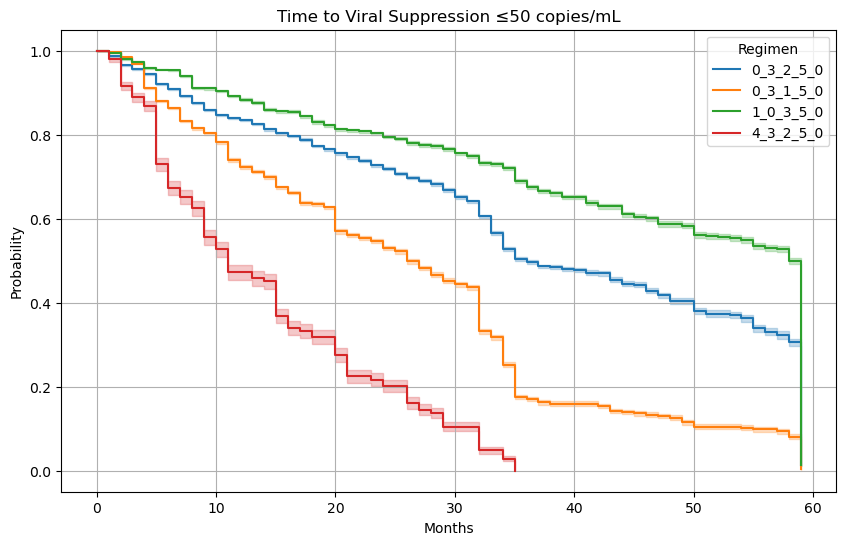

In [32]:
km('vl50')

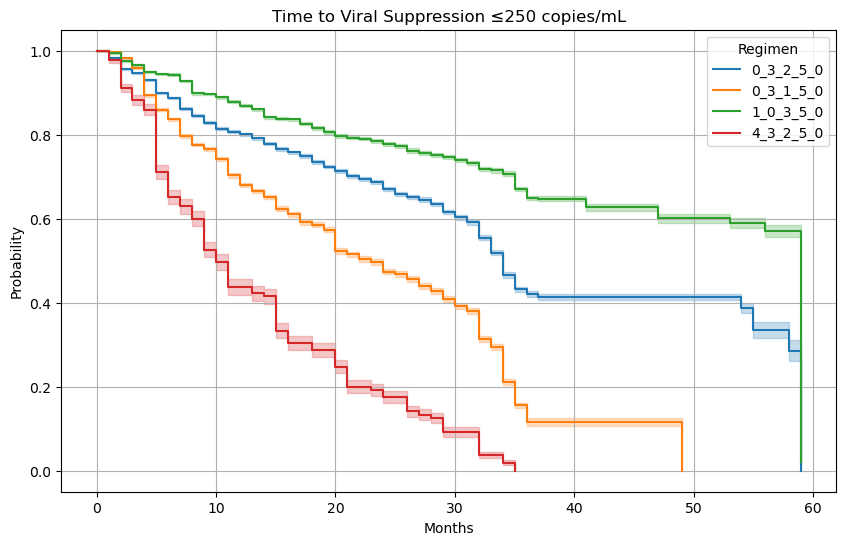

In [31]:
km('vl250')

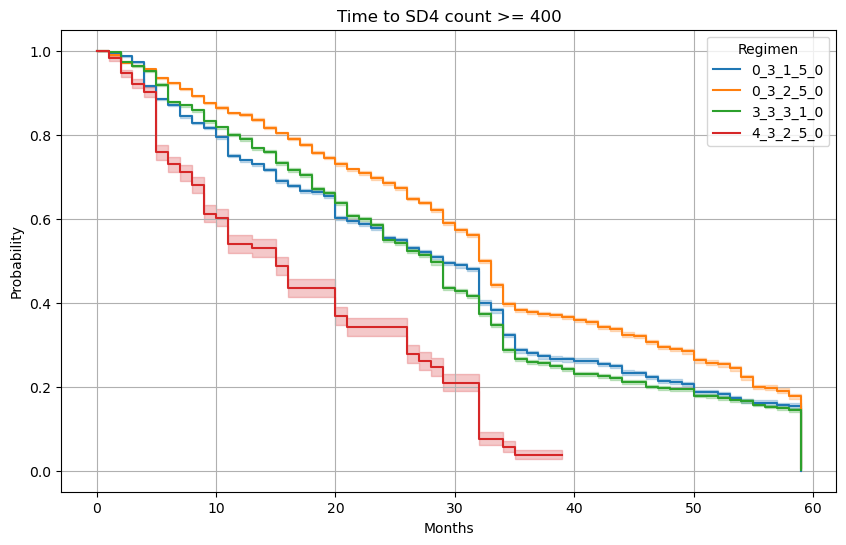

In [33]:
km('cd4_500')

In [88]:
mode = 'vl50'
filtered_intervals_outcomes = filter_intervals(intervals_outcomes, mode)

tv_data = []
for _, row in filtered_intervals_outcomes.iterrows():
    start = row['Start']
    if mode == 'vl50':
        end = row['End'] if row['VL_50_Censored'] == 1 else row['VL_50_time']
    elif mode == 'vl250':
        end = row['End'] if row['VL_250_Censored'] == 1 else row['VL_250_time']
    else:
        end = row['End'] if row['CD4_500_Censored'] == 1 else row['CD4_500_time']
    
    tv_data.append({
        'Patient ID': row['ID'],
        'start': start,
        'stop': end,
        'gender': row['Gender'],
        'ethnicity': row['Ethnicity'],
        'censor': row['VL_50_Censored'],
        'Regimen': row['Regimen'],
        'Baseline_VL': row['Baseline_VL'],
        'Baseline_CD4': row['Baseline_CD4']
    })

tv_df = pd.DataFrame(tv_data)

In [91]:
tv_df

,Patient ID,start,stop,gender,ethnicity,censor,Regimen,Baseline_VL,Baseline_CD4,Regimen_lumped
0,30133543973798,0,36.0,2,4,1,0_1_3_5_0,93638.856272,920.185769,0_1_3_5_0
1,198464063523553,0,2.0,1,4,0,3_3_3_1_0,366.100140,269.793482,3_3_3_1_0
2,198464063523553,35,36.0,1,4,0,2_3_3_0_1,95.778029,370.000890,Other
3,198464063523553,46,47.0,1,4,0,2_3_3_0_1,99.126804,368.075806,Other
4,198464063523553,57,59.0,1,4,1,2_3_3_0_1,96.171445,396.694360,Other
...,...,...,...,...,...,...,...,...,...,...
369019,18446294480367750440,12,19.0,1,4,1,0_3_2_5_0,44307.987161,268.256394,0_3_2_5_0
369020,18446294480367750440,20,21.0,1,4,1,4_3_2_5_0,36263.209696,436.372050,4_3_2_5_0
369021,18446294480367750440,22,35.0,1,4,0,0_3_2_5_0,10553.382873,306.230922,0_3_2_5_0
369022,18446335763543073043,0,16.0,2,4,0,3_3_3_1_0,249.331672,277.662503,3_3_3_1_0


In [92]:
counts = tv_df["Regimen"].value_counts()
common_regimens = counts[counts > 1000].index

# 2) Lump less frequent regimens into "Other"
tv_df["Regimen_lumped"] = tv_df["Regimen"].apply(lambda x: x if x in common_regimens else "Other")
tv_df["Regimen_lumped"] = tv_df["Regimen_lumped"].astype("category")
tv_df["gender"] = tv_df["gender"].astype("category")
tv_df["ethnicity"] = tv_df["ethnicity"].astype("category")

categorical_cols = ['Regimen_lumped', 'gender', 'ethnicity']
continuous_cols = ['Baseline_VL', 'Baseline_CD4']

encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(tv_df[categorical_cols])
X = pd.concat([X_categorical, tv_df[continuous_cols].reset_index(drop=True)], axis=1)

y = np.array([(row['censor'], row['stop']) for _, row in tv_df.iterrows()], 
             dtype=[('event', 'bool'), ('time', 'f8')])


In [ ]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X, y)

# 8) Feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rsf.feature_importances_
}).sort_values(by="Importance", ascending=False)